# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć neuronowa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import np_utils

### Ustawienia

In [2]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [40]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
image_size = (100, 100)
# image_size = (64, 64)
# image_size = (32, 32)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [4]:
def generator_to_array(data_generator):
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        data_list.append(data[0])
        batch_index = batch_index + 1

    data_array = np.asarray(data_list, dtype=object)
    X = np.concatenate(data_array, axis=0)
    y = data_generator.classes
    y = np_utils.to_categorical(y)
    return (X, y)

In [5]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [6]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [7]:
target = ['Oponiak', 'Glejak', 'Guz przysadki']

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_ax = plt.subplots(1, 1, figsize = (5, 3))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [83]:
import cv2

def blur(img):
    return (cv2.blur(img, (2,2)))

In [131]:
train_generator = ImageDataGenerator(
    horizontal_flip=True,
#     vertical_flip=True,
    brightness_range=(0.8, 1.5),
#     brightness_range=(1.0, 2.0),
#     preprocessing_function=blur,
)

def get_train_generator():
    return train_generator.flow_from_directory(
            train_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
#             color_mode='grayscale',
#             interpolation = 'lanczos',
            shuffle=True)

train_data_generator = get_train_generator()
train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)

Found 3678 images belonging to 3 classes.


In [130]:
test_generator = ImageDataGenerator()

def get_test_generator():
    return test_generator.flow_from_directory(
            val_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
#             color_mode='grayscale',
#             interpolation = 'lanczos',
            shuffle=False)

test_data_generator = get_test_generator()
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 600 images belonging to 3 classes.


### Próbka zbioru treningowego

Found 3678 images belonging to 3 classes.


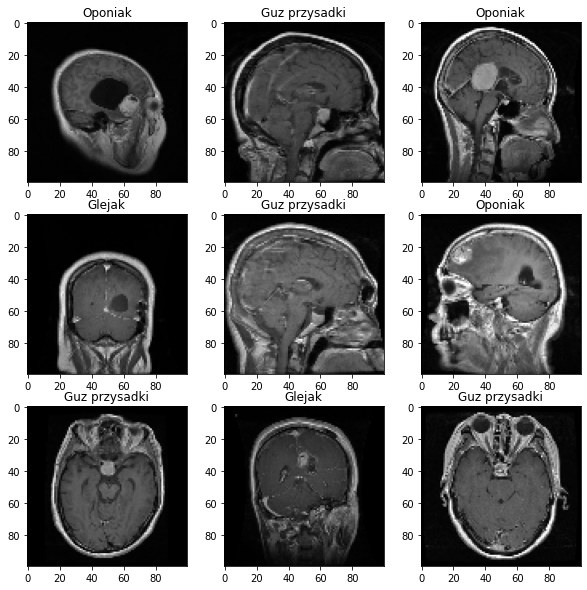

In [132]:
plt.figure(figsize=(10, 10))

b = next(train_data_generator)

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"), cmap='gray')
    label = cancer_type[np.argmax(label)]
    plt.title(label)
    
train_data_generator = get_train_generator()

## Model

In [133]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, optimizer="adam"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=image_size + (3,)))
#     model.add(keras.layers.InputLayer(input_shape=image_size + (1,)))
#     model.add(keras.layers.InputLayer(input_shape=image_size))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Flatten())
    
    model.add(Dense(200,activation="relu"))
    model.add(Dense(100,activation="relu"))
    model.add(Dense(50,activation="relu"))
    model.add(Dense(10,activation="relu"))
    model.add(Dense(3,activation="softmax"))
    
#     model.add(keras.layers.Dense(300, activation = 'relu' ))
#     model.add(keras.layers.Dense(100, activation = 'relu' ))
#     model.add(keras.layers.Dense(100, activation = 'relu' ))
#     model.add(keras.layers.Dense(100, activation = 'relu' ))
    
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
#     model.add(keras.layers.Dense(3, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
#     optimized = 'sgd'
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[
            "categorical_accuracy",
            "accuracy",
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
        ],
    )

    return model

In [134]:
# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
model = build_model()

In [126]:
build_model().summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_133 (Dense)            (None, 200)               6000200   
_________________________________________________________________
dense_134 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_135 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_136 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_137 (Dense)            (None, 3)               

In [119]:
X_train, y_train = generator_to_array(get_train_generator())
X_test, y_test = generator_to_array(get_test_generator())

Found 3678 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [120]:
X_train.shape

(3678, 100, 100, 3)

In [121]:
y_train.shape

(3678, 3)

In [122]:
from sklearn.utils import class_weight

y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.0, 1: 1.0, 2: 1.0}

In [135]:
epochs = 15

param_distribs = {
    "n_hidden": [2, 3, 4],
    "n_neurons": np.arange(100, 400),
    "learning_rate": [0.01, 0.001, 0.0001],
#     "optimizer": ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
#     "optimizer": ['Adam']
}


callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
]

# rnd_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=5, cv=5, verbose=2)
# # rnd_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=1, cv=2, verbose=2)
# # rnd_search_cv.fit(
history = History()
# history = model.fit(
#     X_train,
# #     X_test,
#     y_train,
# #     y_test,
#     epochs=epochs, 
#     validation_split=0.2,
#     callbacks=callbacks,
#     class_weight=class_weights,
# )

history = model.fit(
#     X_train,
#     y_train,
    get_train_generator(), 
    validation_data=get_test_generator(), 
#     validation_data=(X_test, y_test), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
)


Found 3678 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/15
115/115 [==============================] - 24s 189ms/step - loss: 0.8852 - categorical_accuracy: 0.5854 - accuracy: 0.5854 - precision: 0.7956 - recall: 0.2836 - auc: 0.7899 - val_loss: 0.7995 - val_categorical_accuracy: 0.6267 - val_accuracy: 0.6267 - val_precision: 0.7722 - val_recall: 0.3333 - val_auc: 0.8358
Epoch 2/15
115/115 [==============================] - 21s 182ms/step - loss: 0.7074 - categorical_accuracy: 0.6811 - accuracy: 0.6811 - precision: 0.7512 - recall: 0.5237 - auc: 0.8673 - val_loss: 0.6900 - val_categorical_accuracy: 0.6833 - val_accuracy: 0.6833 - val_precision: 0.7476 - val_recall: 0.5283 - val_auc: 0.8737
Epoch 3/15
115/115 [==============================] - 22s 193ms/step - loss: 0.6374 - categorical_accuracy: 0.7047 - accuracy: 0.7047 - precision: 0.7456 - recall: 0.6319 - auc: 0.8869 - val_loss: 0.6278 - val_categorical_accuracy: 0.7217 - val_accuracy: 0.7217 - val

In [35]:
# rnd_search_cv.best_params_

In [ ]:
# model = rnd_search_cv.best_estimator_

# history = History()

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=epochs, 
#     validation_split=0.2,
#     callbacks=callbacks,
# )

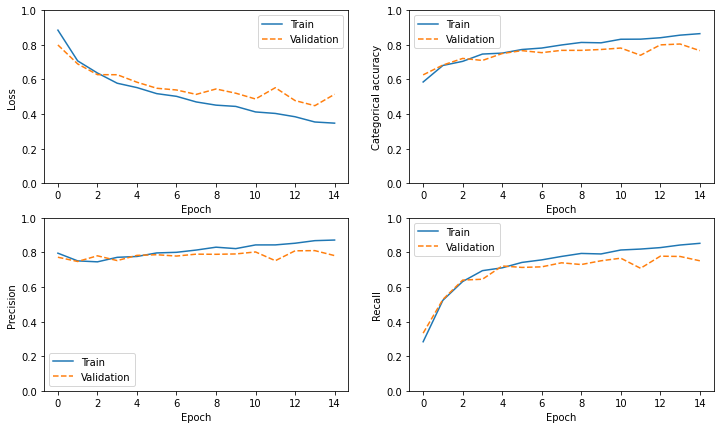

In [136]:
plot_metrics(history)

In [143]:
predictions = model.predict_proba(X_test)
# predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(model.predict(X_test), axis=1)

true_classes = np.argmax(y_test, axis=1)
class_labels = list(test_data_generator.class_indices.keys())

In [144]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.69      0.76      0.72       200
           2       0.84      0.58      0.69       200
           3       0.81      0.99      0.89       200

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.77       600
weighted avg       0.78      0.78      0.77       600



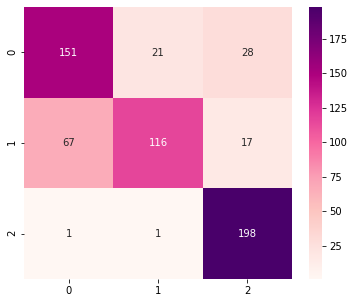

In [145]:
plot_confusion_matrix(predicted_classes, true_classes)

ROC AUC score: 0.9282791666666665


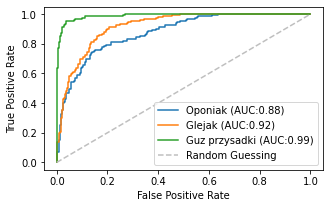

In [140]:
plot_roc_curve(y_test, predictions)
# plot_roc_curve(y_train, predictions)

In [141]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [142]:
img = keras.preprocessing.image.load_img(
    "data/val/3/13.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(X_train.shape)

p = model.predict_proba(img_array)
score = p[0]
print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)

[8.8405400e-04 4.2396206e-03 9.9487633e-01]
Oponiak : 0.09%
Glejak : 0.42%
Guz przysadki : 99.49%


C:\Users\Hubert\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
